In [4]:
from typing import Any

from src.model_db.tiny_model_db import TinyModelDB

import numpy as np
import networkx as nx
import matplotlib.pyplot as plt

from src.reinforcement_learning.core.policy_info import PolicyInfo
from src.model_db.model_db import ModelEntry


In [11]:
env_name = 'Humanoid-v4'    
with TinyModelDB(base_path=f'E:/saved_models/rl/Humanoid-v4/mitosis-2024-05-03_19.31.53') as policy_db:
    policy_entries_sorted: list[ModelEntry[PolicyInfo]] = list(sorted(policy_db.all_entries(), key=lambda p: p['model_info']['score'], reverse=True))

In [12]:
for policy_entry in policy_entries_sorted:
    print(f"id = {policy_entry['model_id']}, score = {policy_entry['model_info']['score']:6.4f}, parent_id = {str(policy_entry['parent_model_id'])}")

id = 2024-05-04_00.20.23~MV6RVg, score = 146.8099, parent_id = 2024-05-03_23.43.45~3uRz5g
id = 2024-05-03_23.43.45~3uRz5g, score = 131.1047, parent_id = 2024-05-03_23.16.07~Ntmb7N
id = 2024-05-03_23.25.23~F54ySp, score = 128.3197, parent_id = 2024-05-03_22.48.06~ZTYgTN
id = 2024-05-03_23.34.33~z9rEfe, score = 125.2646, parent_id = 2024-05-03_23.16.07~Ntmb7N
id = 2024-05-03_23.16.07~Ntmb7N, score = 119.1929, parent_id = 2024-05-03_22.20.12~h4k0Gh
id = 2024-05-03_22.48.06~ZTYgTN, score = 119.1555, parent_id = 2024-05-03_21.43.20~RfUGC7
id = 2024-05-03_23.52.58~bSXC4u, score = 117.9283, parent_id = 2024-05-03_21.43.20~RfUGC7
id = 2024-05-04_00.11.21~MQ4D7Q, score = 113.2175, parent_id = 2024-05-03_23.25.23~F54ySp
id = 2024-05-03_21.43.20~RfUGC7, score = 109.0384, parent_id = 2024-05-03_21.09.57~l028kP
id = 2024-05-03_22.20.12~h4k0Gh, score = 108.0586, parent_id = 2024-05-03_21.43.20~RfUGC7
id = 2024-05-04_00.02.10~DQW8KB, score = 106.8704, parent_id = 2024-05-03_23.52.58~bSXC4u
id = 2024-

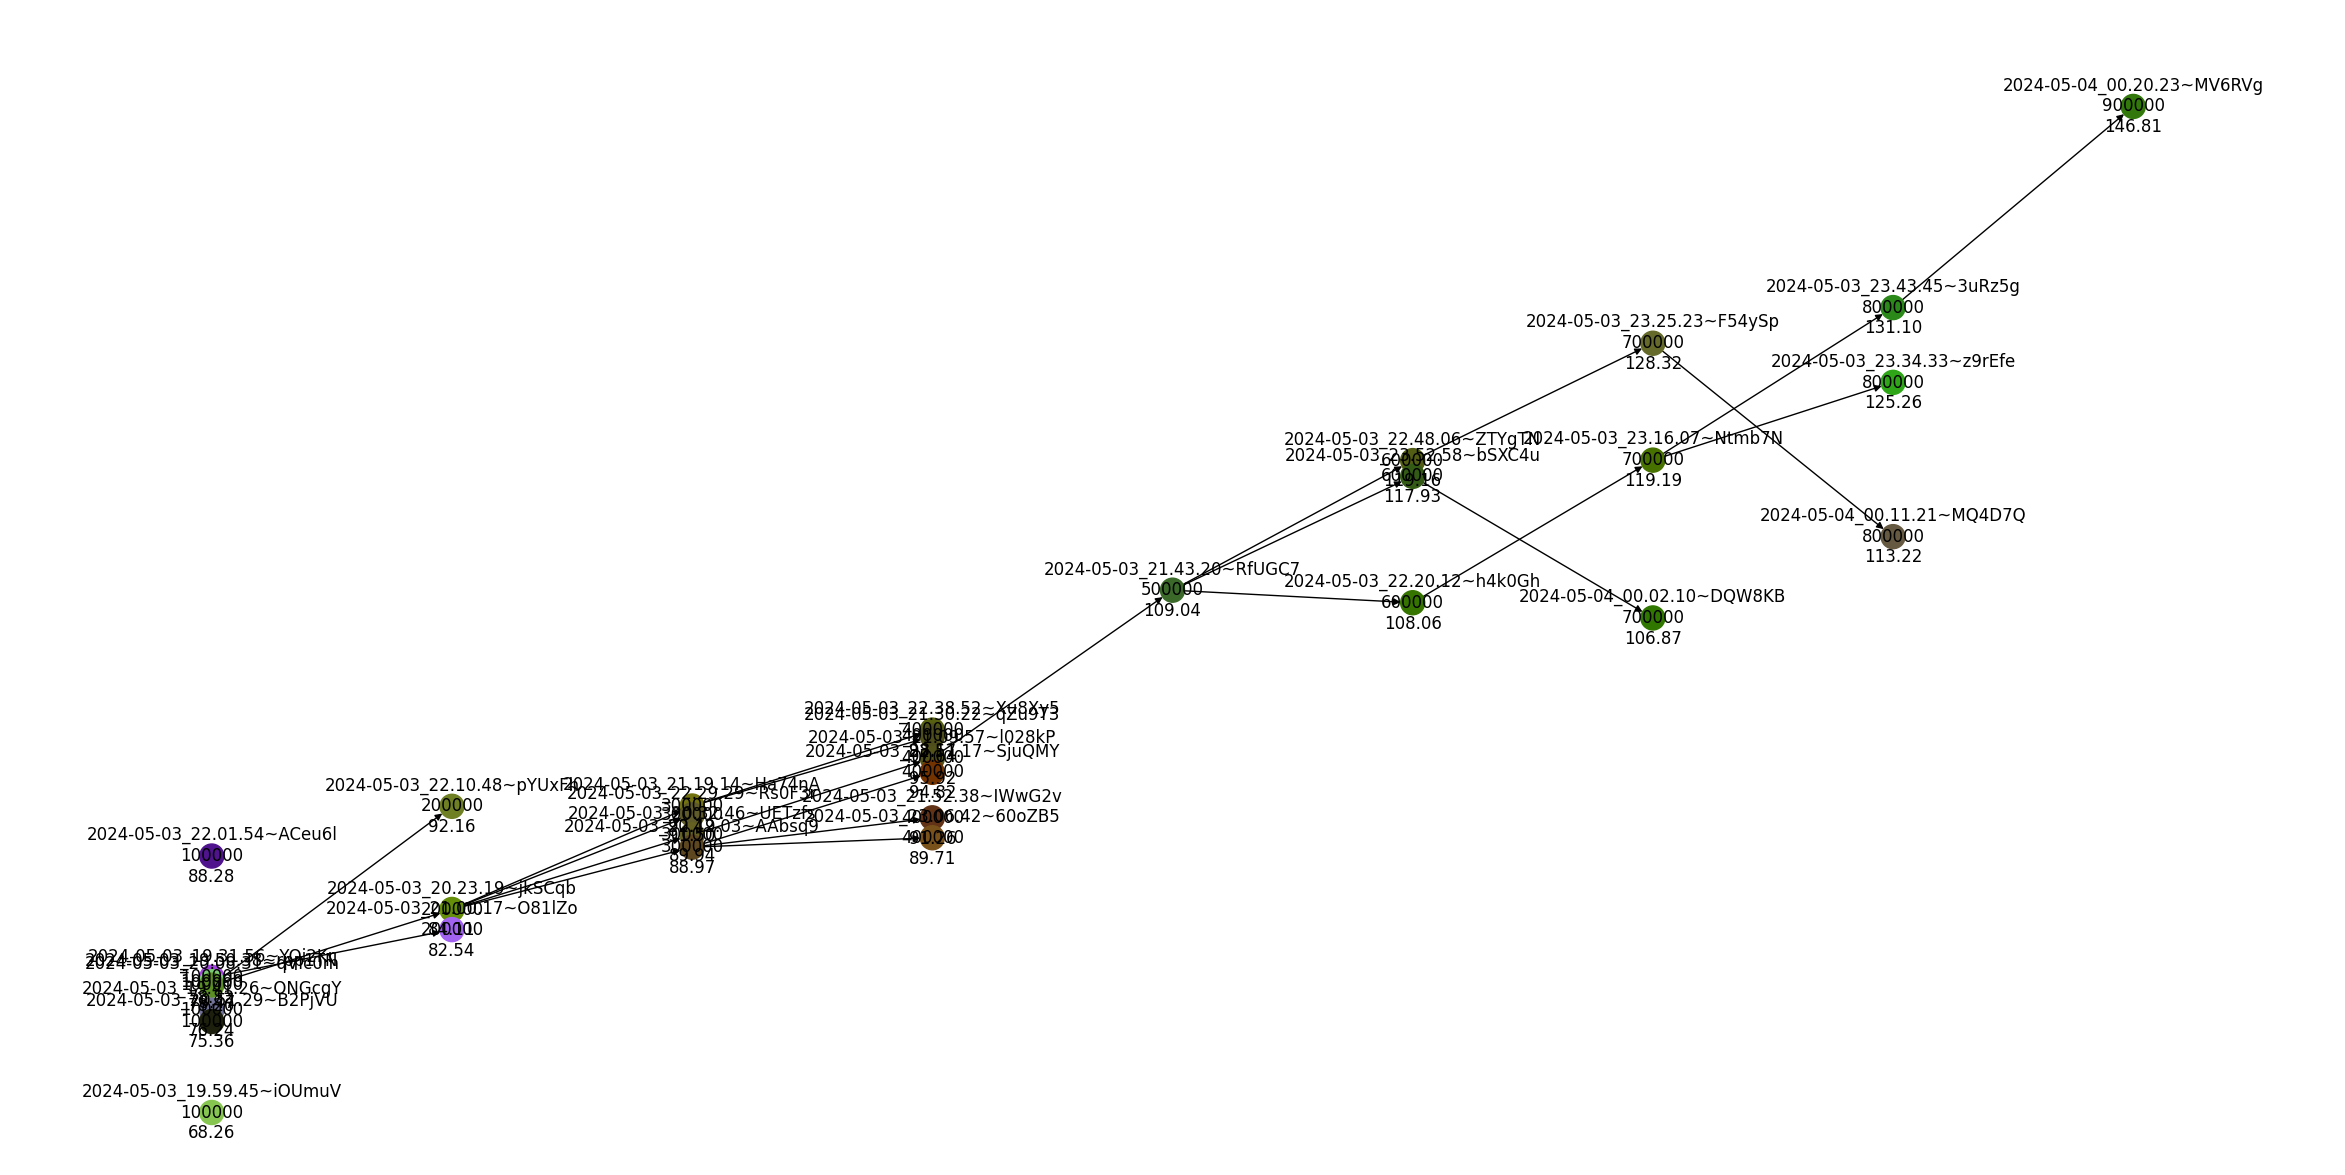

In [13]:
G = nx.DiGraph()

G.add_nodes_from(
    (policy_entry['model_id'], {
        'score': policy_entry['model_info']['score'], 
        'steps_trained': policy_entry['model_info']['steps_trained']
    })
     for policy_entry 
     in policy_entries_sorted
     )

pos: dict[str, tuple[int, float]] = {}
for policy_entry in policy_entries_sorted:
    model_id = policy_entry['model_id']
    parent_id = policy_entry['parent_model_id']
    if parent_id is not None:
        G.add_edge(parent_id, model_id)
    
    model_info = policy_entry['model_info']
    pos[model_id] = (model_info['steps_trained'], model_info['score'])


def set_color_recursively(node_id: str, c: Any):
    colors[node_id] = c
    for neighbor_id in G.neighbors(node_id):
        c = np.clip(c + (np.random.random(3) - 0.5) / 4, 0, 1)
        set_color_recursively(neighbor_id, c)
    

colors: dict[str, np.ndarray] = {}
for root_id in (node for node, in_degree in G.in_degree() if in_degree == 0):
    color = list(np.random.random(3))
    set_color_recursively(root_id, color)

node_color = [colors[node_id] for node_id in G]

scores = nx.get_node_attributes(G, 'score')
steps_trained = nx.get_node_attributes(G, 'steps_trained')
labels: dict[str, str] = {}
for node_id, score in scores.items():
    labels[node_id] = f'{node_id}\n{steps_trained[node_id]}\n{score:.2f}'

fig, ax = plt.subplots(1, 1, figsize=(30, 15))
nx.draw(G, pos, with_labels=True, labels=labels, node_color=node_color, ax=ax)


In [10]:
model_id = '2024-04-30_22.08.06'

def print_dict(d: dict):
    for key, value in d.items():
        if isinstance(value, dict):
            print(f"↓↓↓  {key:^15}  ↓↓↓")
            print_dict(value)
            print(f"↑↑↑  {key:^15}  ↑↑↑\n\n")
        else:
            print(f"======  {key:^15}  ======\n{value}\n")

print_dict(policy_db.fetch_entry(model_id))

ValueError: I/O operation on closed file.

In [3]:
policy_db.delete_entry('2024-04-30_09.24.10', delete_state_dict=True)